# 上司向けの部下とのキャリア面談研修の効果　~T-learnerによる効果検証~
下記の書籍のP104 - P110を加筆・修正したものになります
- https://book.mynavi.jp/ec/products/detail/id=115805

In [1]:
import random 
import numpy as np

from numpy.random import *

import matplotlib.pyplot as plt
import japanize_matplotlib
import scipy.stats

from scipy.special import expit

import pandas as pd

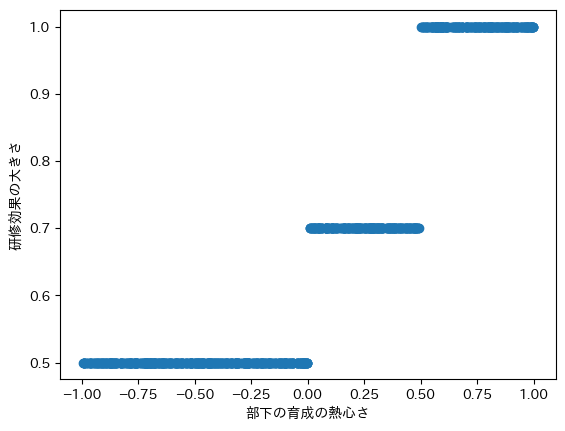

In [2]:
# データ数
num_data = 1000

# 部下育成への熱心さ
passionate=np.random.uniform(low=-1, high=1, size=num_data)

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z=randn(num_data)
z_prob=expit(-5.0*passionate + 5*e_z)

intervention_flg=np.array([])

for i in range(num_data):
    intervention_flg_i=np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    intervention_flg=np.append(intervention_flg, intervention_flg_i)


# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
intervention_effect_score=np.zeros(num_data)
for i in range(num_data):
    if passionate[i]<0:
        intervention_effect_score[i]=0.5
    elif passionate[i] >= 0 and passionate[i]<0.5:
        intervention_effect_score[i]=0.7
    elif passionate[i]>=0.5:
        intervention_effect_score[i]=1.0

e_y=randn(num_data)
satisfaction=2.0 + intervention_effect_score*intervention_flg + 0.3*passionate + 0.1*e_y

plt.scatter(passionate, intervention_effect_score, label='tretment- effect')
plt.xlabel('部下の育成の熱心さ')
plt.ylabel('研修効果の大きさ')
plt.show()
plt.clf()
plt.close()

In [3]:
df=pd.DataFrame({'部下教育の熱心さ':passionate
                 , '介入フラグ':intervention_flg
                 , '介入効果':intervention_effect_score
                 ,'面談満足度':satisfaction
                  })
df.head()

,部下教育の熱心さ,介入フラグ,介入効果,面談満足度
0,0.212760,1.0,0.7,2.677950
1,-0.021972,1.0,0.5,2.455870
2,-0.846389,0.0,0.5,1.727620
3,0.921264,1.0,1.0,3.143440
4,0.079997,0.0,0.7,1.890124


In [4]:
plt.scatter(passionate, satisfaction)
plt.xlabel('部下の育成の熱心さ X')
plt.ylabel('キャリア面談の満足度 Y')
plt.clf()
plt.close()


In [5]:
df_0=df[df['介入フラグ']==0.0] # 介入を受けていない集団
df_1=df[df['介入フラグ']==1.0] # 介入を受けた集団

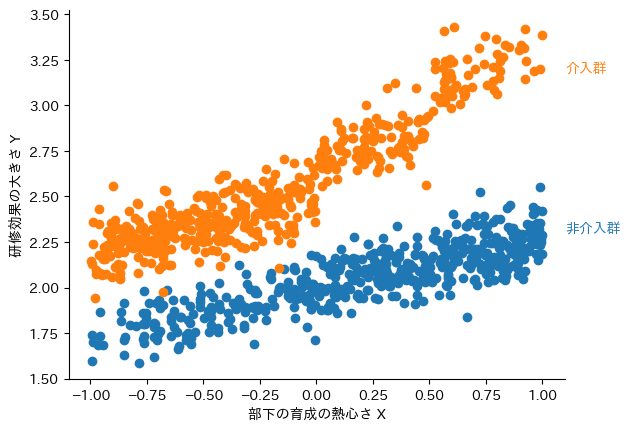

In [6]:
plt.scatter(df_0['部下教育の熱心さ'], df_0['面談満足度'])
plt.scatter(df_1['部下教育の熱心さ'], df_1['面談満足度'])

plt.xlabel('部下の育成の熱心さ X')
plt.ylabel('研修効果の大きさ Y')

plt.text(1.1,df_0['面談満足度'].max()-0.25, '非介入群', color='tab:blue')
plt.text(1.1,df_1['面談満足度'].max()-0.25, '介入群', color='tab:orange')


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()
plt.clf()
plt.close()

In [7]:
from sklearn.model_selection import train_test_split


# train, test半分ずつに分ける
X_train, X_test, w_train, w_test, y_train, y_test = train_test_split(df['部下教育の熱心さ'], df['介入フラグ'], df['面談満足度'], test_size=0.5, random_state=0)


In [8]:
from sklearn.ensemble import RandomForestRegressor

# --- Two-Model Approach ---
# 非介入群(control)と介入群(treat)それぞれについてランダムフォレストで学習

# 非介入群
reg_0=RandomForestRegressor(max_depth=3)
reg_0.fit(np.array([X_train[w_train == 0]]).reshape(-1,1)
          , y_train[w_train == 0]
)

# 介入群
reg_1=RandomForestRegressor(max_depth=3)
reg_1.fit(np.array([X_train[w_train == 1]]).reshape(-1,1)
          , y_train[w_train == 1]
)




RandomForestRegressor(max_depth=3)

In [9]:
mu_0=reg_0.predict(np.array([X_test]).reshape(-1,1))
mu_1=reg_1.predict(np.array([X_test]).reshape(-1,1))

ATE=(mu_1-mu_0).mean()
print('ATE: ', ATE)

ATE:  0.6781994417663986


In [10]:
ATT=np.array(y_test[w_test==1])- mu_0[w_test==1] # 介入群の実際のY - 介入群がもし非介入群だったらのY
ATU=mu_1[w_test==0] - np.array(y_test[w_test==0]) # 非介入群がもし介入群だったらのY - 非介入群がもし介入群だったらのY


print('ATT: ', ATT.mean())
print('ATU: ', ATU.mean())

ATT:  0.5980007352457387
ATU:  0.7434666048880109


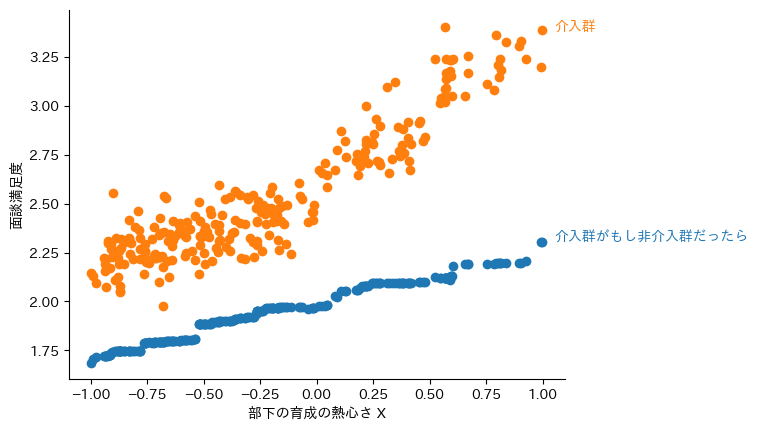

In [11]:
# 介入群の実際の満足度と介入群がもし非介入群だった時の満足度
plt.scatter(X_test[w_test==1],mu_0[w_test==1], color='tab:blue')
plt.scatter(X_test[w_test==1],y_test[w_test==1], color='tab:orange')

plt.text(1.05, mu_0[w_test==1].max(), '介入群がもし非介入群だったら', color='tab:blue')

y_index=X_test[w_test==1][X_test[w_test==1]==X_test[w_test==1].max()].index
plt.text(1.05, y_test[w_test==1][y_test[w_test==1].index==y_index[0]].values[0], '介入群', color='tab:orange')

plt.xlabel('部下の育成の熱心さ X')
plt.ylabel('面談満足度')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()
plt.clf()
plt.close()

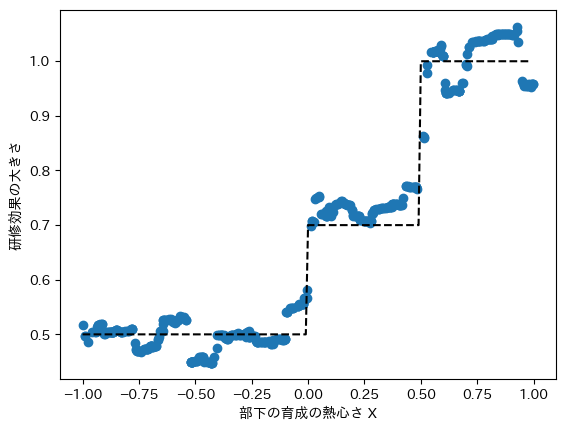

In [12]:


# 黒い点線を描くためのデータ作成---------------------
x_index=np.arange(-1, 1, 0.01)
t_ans=np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i]=0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i]=0.7
    elif x_index[i]>=0.5:
        t_ans[i]=1.0
# ------------------------------------------------

# 推定効果を算出する
t_estimated=mu_1-mu_0
plt.scatter(X_test, t_estimated
            , label='estimated_treatment-effect')
# 黒い点線を書く---------------------------------------------
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')
# ----------------------------------------------------------

plt.xlabel('部下の育成の熱心さ X')
plt.ylabel('研修効果の大きさ')

plt.show()
plt.clf()
plt.close()